# Spoofing Facial Recognition - Shreyas Rao



Facial recognition is gaining increasing traction as a means to authenticate. This makes it a prime target for spoofing attacks. In this notebook, we investigate whether having an enrollment image with a smile is more susceptible to spoofing than a neutral enrollment image. Based on that analysis, we will decide if users should be prevented from using a smiling reference image to authenticate themselves.

Key terms:
* Enrollment image: the image used as the known person in the recognition program
* True positive (TP): image CORRECTLY identified as the enrollment image
* False positive (FP): image INCORRECTLY identified as the enrollment image (SPOOF)
* True negative (TN): image CORRECTLY identified as NOT the enrollment image
* False negative (FN): image INCORRECTLY identified as NOT the enrollment image

For facial recognition, we used this open source project:

https://github.com/ageitgey/face_recognition/

Once installed, we can run face_recognition from terminal:

Output is a list of filenames located in the unknown folder, followed by the names of face it recognizes from the known folder. Since we are investigating spoofing with one shot face recognition, there is only one picture present in the known folder.

## Data Preparation

We will be using a series of publicly available face datasets. Each file is named using a subjectID, expression (smile, neutral, etc.) and an optional number. We reformat each file as follows to have a universal naming scheme across all datasets:

("original"|"transformed")-(subjectID)-(expression)-(imageID).jpg

Once we have reformatted the names, we grouped them in different folders as "smile" or "neutral"


## Initial Analysis
In order to confirm that smiling enrollment images were in fact more likely to be spoofed, we check if the number of false positives in smiling image subset is in fact greater than false positives in neutral subset

### Batch Processing:
For our initial tests, we will be using the FM dataset which is a series of manually aligned frontal images of subjects with smiling and neutral images:
https://github.com/shreyasrao/public/tree/master/unifyIdProject/fmDataSetCombined/smile
https://github.com/shreyasrao/public/tree/master/unifyIdProject/fmDataSetCombined/neutral

To process the entire dataset, we have to first set up the batch test zone.
https://github.com/shreyasrao/public/tree/master/unifyIdProject/fmDataSetCombined/batchTestZone/neutralBatchTest

Directory structure:
* all : all of the pictures belonging to this dataset and expression
* known: leave empty. Script will populate this folder accordingly
* empty & noFaceDetected: leave empty. Script uses these for error handling

Since running the test against all the images for all tolerance levels takes a long time (1-2 hours on my machine), I decided to randomize the batch testing process. A script selects a subject id for each tolerance level randomly based on the images in the neutral folder. Then we run the batch test script using the randomly generated subject IDs.

The randomized batch test script does the following:
* Checks if it can find a face in all images in the "all" folder. This is done by running face_regonition in the "all" folder against the "empty" folder
    * If no face is found, a warning is raised, and that file is moved to the noFaceDetected folder and excluding from our runs
* For each tolerance value in range(0,100):
    * Find the random subject ID corresponding to the tolerance level
    * Select that image from "all" folder and copy to "known" folder with the name "enrolled.jpg". This is the enrollment step
        * A run is performed against this enrolled image. We parse the output and calculate TP, FP, TN, FN counts
        * A global count is update after each new enrollment image using the tolerance value from earlier
    * The count totals are printed to console and cleared for the next run which will use a new tolerance value

The script outputs all the counts onto terminal. Pipe the output to a txt file and pass it to grabData.py:

We can easily modify grabData to capture any metric of our interest but currently it's only grabbing the FP counts. Repeat the same steps for the smile images and copy the data:

In [50]:
import numpy as np
n = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 3, 1, 0, 1, 6, 18, 16, 11, 22, 20, 28, 29, 13, 79, 92, 43, 84, 105, 83, 100, 125, 139, 148, 88, 175, 156, 138, 182, 176, 189, 149, 195, 194, 194, 197, 195, 199, 198, 198]
neutralFPSum = np.sum(n[50:80])
print(neutralFPSum)
s = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 4, 2, 5, 3, 2, 24, 16, 16, 8, 19, 18, 18, 33, 33, 65, 99, 44, 107, 96, 108, 140, 121, 154, 155, 120, 182, 188, 125, 168, 185, 192, 166, 198, 193, 196, 199, 196, 199, 198, 199]
smileFPSum = np.sum(s[50:80])
print(smileFPSum)

662
724


We see that in a tolerance range of 0.55-0.8, smile images are in fact getting more false positives. Although this isn't an issue at lower tolerances (since the recognition is very robust), we will investigate whether we can reduce that difference by somehow transforming the enrollment image. This way, a user could select any enrollment image of their choice.

## Initial Attempts

### Perspective Filter
Our first idea was to remove the smile from the enrollment image. All material referenced opencv and dlib modules. After struggling with it quite some time, we were only able to install dlib but not openCV on mac OS. Since these two modules are in heavy use in the image modification space, we had to use a different approach. We then attempted to manually transform the image using a perspective filter. The motivation for this came from the observation that the spoof outlined in the paper had Vinay and John take smile enrollment pictures at an angled pose. We attempted to correct this, in the hopes that the transformed smile image would have a much different encoding than the other smile images. Using some online material we implemented a perspective filter using PIL:

From test runs, it became obvious that the approach did not help. In fact it generated orders of magnitude more 
false positives than the smiling enrollment image.

### Modifying the API
Then we turned to the face_recognition program which was at the heart of the analysis. Instead of altering the image to alter the encoding, we wanted to see if we could alter the API. We found the command 'face_recognition' is a wrapper for cli.py:

https://github.com/ageitgey/face_recognition/blob/master/face_recognition/cli.py

Cli.py internally makes calls to api.py:

https://github.com/ageitgey/face_recognition/blob/master/face_recognition/api.py

So api.py was the backend logic for the image detection module. Specifically, 'compare_faces' calls 'face_encodings' which returns a 128D vector based on the face landmarks identified. If the distance between the known encoding and the unknown encoding is less than the tolerance parameter, a match is found.

We attempted modify the encoding for images such that landmarks related to a smiling face ('top lip', 'bottom lip') would be randomized from a set of neutral lip/mouth landmarks. This would increase the distance between true positives, and hopefully past the threshold for a match. Modifying landmarks required tinkering with a dlib full_object_detection object that is returned from raw_landmarks.

http://dlib.net/python/index.html

Soon it became clear that we couldn't modify mouth landmarks in full_object_detection object. We decided to construct a new object with our modified landmark data. full_object_detection was created after a call to shape_predictor. Tinkering with the shape predictor model would make intensive changes to the face recognition program, so we decided to try a different approach.

## A Ray of Hope

Running out of ideas and time, we decided to go all in on image transformation. We still were not able to get openCV running on mac, so we installed Ubuntu. We were able to install openCV relatively easily. The euphoria didn't last long, as we soon discovered that dlib would not compile. After trying various "solutions" with no luck, our backs were against the wall. In one last move of desperation, we checked online for a VM with openCV and dlib installed ... and Viola!!! A gift from the gods:

https://medium.com/@ageitgey/try-deep-learning-in-python-now-with-a-fully-pre-configured-vm-1d97d4c3e9b

Now that everything was up and running, we wanted to check if there were any tools for blending faces. We came across this amazing tool by Matthew Earl:

https://matthewearl.github.io/2015/07/28/switching-eds-with-python/
https://github.com/matthewearl/faceswap/blob/master/faceswap.py

Not only did Matt create an excellent face blending algorithm, but we could toggle its effect on an image by manipulating the OVERLAY_POINTS vector and COLOUR_CORRECT_BLUR_FRAC value. 

### Experiments with Image Blending
For the first attempt, we blurred the eyes and mouth of smiling images with 3 random people from the neutral dataset. We wanted to see if this was too much blending (if there was such a thing):

We also created another set of transformed images where we only blended the mouth of a smiling image with one random neutral image.

We ran the randomized batch test script from earlier and used gradData.py for data collection:

Neutral:662
Smile: 724
Smile blend 3 faces: 839
Smile blend 1 face: 681


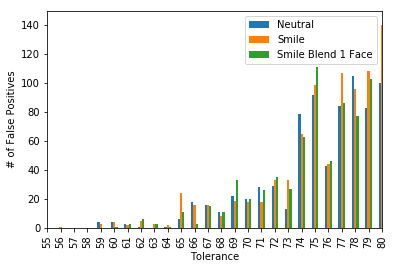

In [12]:
import matplotlib
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Neutral FP
n = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 3, 1, 0, 1, 6, 18, 16, 11, 22, 20, 28, 29, 13, 79, 92, 43, 84, 105, 83, 100, 125, 139, 148, 88, 175, 156, 138, 182, 176, 189, 149, 195, 194, 194, 197, 195, 199, 198, 198]

# Smile FP
s = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 4, 2, 5, 3, 2, 24, 16, 16, 8, 19, 18, 18, 33, 33, 65, 99, 44, 107, 96, 108, 140, 121, 154, 155, 120, 182, 188, 125, 168, 185, 192, 166, 198, 193, 196, 199, 196, 199, 198, 199]

# Smile FP with blend eyes and mouth from 3 neutral images
modS = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 4, 6, 4, 6, 7, 23, 23, 12, 33, 64, 31, 77, 86, 95, 71, 58, 84, 74, 78, 173, 166, 134, 129, 149, 143, 159, 172, 173, 187, 170, 175, 196, 197, 194, 198, 198, 199, 198, 199]

# Smile FP with blended mouth from one neutral image
modS_1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 6, 3, 1, 11, 3, 15, 11, 33, 20, 26, 35, 27, 63, 111, 46, 86, 77, 103, 103, 133, 121, 149, 125, 175, 176, 131, 177, 183, 189, 170, 199, 196, 198, 199, 199, 199, 199, 199]

d = {'Neutral' : pd.Series(n),'Smile' : pd.Series(s), 'Smile Blend 1 Face' : pd.Series(modS_1), }

df = pd.DataFrame(d)
b = df.plot.bar()
b.set_xlim(55,80)
b.set_ylim(0,150)
b.set_xlabel("Tolerance")
b.set_ylabel("# of False Positives")
print("Neutral:" + str(np.sum(n[55:80])))
print("Smile: " + str(np.sum(s[55:80])))
print("Smile blend 3 faces: " + str(np.sum(modS[55:80])))
print("Smile blend 1 face: " + str(np.sum(modS_1[55:80])))

From the batch testing we see that the smile with 1 face blend did exceptionally better than that standard smile enrollment. When adding up the false positives in the tolerance range 0.55 - 0.8, the blended enrollment image was less than 20 errors away from neutral. That's less than a 3% difference! The regular smile enrollment had 62 more errors, almost a 10% difference from neutral. The 3 blend face actually did worse than 1 blend or the original smile image, so we decided not to go in that direction any further.

Next, we repeated this experiment on the Jaffe Dataset:

https://github.com/shreyasrao/public/tree/master/unifyIdProject/jaffeDataSet/smile
https://github.com/shreyasrao/public/tree/master/unifyIdProject/jaffeDataSet/neutral

Earl's swapping script was not able to swap features in the Jaffe dataset. The pictures were all low quality black and white pictures. We still ran our analysis using unmodified images:

In [3]:
# Neutral FP from Jaffe DataSet
n = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 3, 7, 6, 12, 9, 6, 16, 17, 9, 12, 13, 20, 17, 24, 24, 24, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]

# Smile FP from Jaffe DataSet
s = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 5, 6, 2, 9, 1, 14, 14, 6, 18, 20, 12, 23, 16, 25, 15, 25, 25, 25, 28, 28, 28, 26, 26, 28, 27, 28, 28, 28, 29, 28, 28, 27, 29, 28, 28, 28, 29, 28, 28, 28, 28, 27, 28, 29, 28, 27, 28, 28, 28, 28, 28, 28, 28, 27, 28, 28, 28, 28, 28, 28, 28, 28]

print("Neutral FP:" + str(np.sum(n[30:60])))
print("Smile FP: " + str(np.sum(s[30:60])))

Neutral FP:334
Smile FP: 372


We saw that in a tolerance range of 0.30-0.60, there were substantially more false positives in the smiling image subset. This confirmed the earlier observation from the FM dataset. Next we analyzed the ATT dataset:

In [5]:
# Neutral FP from ATT DataSet
n = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 4, 4, 9, 10, 9, 1, 12, 16, 13, 14, 15, 25, 14, 28, 30, 26, 34, 34, 36, 22, 31, 37, 38, 37, 35, 36, 38, 35, 38, 38, 38, 37, 38, 38, 38, 38]

# Smile FP from ATT DataSet
s = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 2, 0, 3, 5, 10, 4, 6, 1, 13, 9, 8, 5, 20, 23, 15, 27, 29, 15, 34, 34, 36, 14, 37, 35, 36, 37, 38, 38, 39, 35, 39, 39, 39, 39, 39, 39, 39, 39]
print("Neutral FP:" + str(np.sum(n)))
print("Smile FP: " + str(np.sum(s)))

Neutral FP:952
Smile FP: 925


Shockingly, even though these pictures were also grayscale and lower resolution than the FM dataset, there were less false positives in the smile pictures. Changing the grabData.py parameters showed there were no false negatives in either neutral or smile subset, indicating that face recognition was somehow more accurate on these pictures.

Even though it appeared as if using a gray scale low resolution picture for the enrollment image could help solve our spoofing problem, we didn't want make any conclusions just yet. People in the smile subset of the Att dataset were not smiling as wide as the people in the FM dataset. That could have had a big effect on the results. To check for this, we went back and changed all the FM images into lower resolution grayscale and ran the tests once again. 

Used this code to covert images to grayscale using cv2:
https://extr3metech.wordpress.com/2012/09/23/convert-photo-to-grayscale-with-python-opencv/

For downsizing images, cv.INTER_AREA is the best interpolation algorithm, according to this analysis:
http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/

We downsized the width to 92 pixels (same as ATT dataset) and scaled height accordingly to keep aspect ratio the same:
http://www.pyimagesearch.com/2014/01/20/basic-image-manipulations-in-python-and-opencv-resizing-scaling-rotating-and-cropping/

Neutral FP:710
Smile FP:709


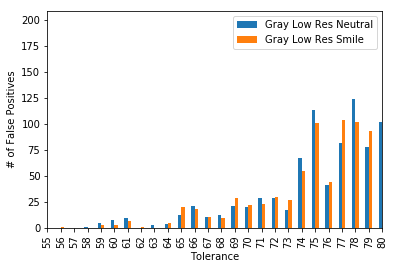

In [11]:
zeros = [0] * 50

# Gray low res neutral FP from FM dataset
nGray = zeros + [0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 8, 10, 0, 3, 4, 13, 21, 11, 13, 21, 20, 29, 29, 17, 67, 113, 41, 82, 124, 78, 102, 122, 147, 154, 116, 177, 164, 131, 185, 170, 190, 156, 193, 194, 197, 197, 195, 199, 198, 198]

# Gray low res smile FP from FM dataset
sGray = zeros + [0, 0, 0, 0, 1, 0, 1, 0, 0, 3, 3, 7, 1, 0, 5, 20, 18, 11, 10, 29, 22, 23, 30, 27, 55, 101, 44, 104, 102, 93, 127, 129, 152, 151, 146, 180, 186, 136, 182, 185, 193, 177, 198, 193, 199, 199, 197, 199, 199, 199]

d = {'Gray Low Res Neutral' : pd.Series(nGray),'Gray Low Res Smile' : pd.Series(sGray)}

df = pd.DataFrame(d)
b = df.plot.bar()
b.set_xlim(55,80)
b.set_xlabel("Tolerance")
b.set_ylabel("# of False Positives")
print("Neutral FP:" + str(np.sum(nGray[55:80])))
print("Smile FP:" + str(np.sum(sGray[55:80])))

Further analysis showed that observations from the ATT Dataset were in fact accurate. Low resolution gray scale images had a noticeably less number of false positives. Just as another sanity check, I combined the neutral and smile subsets, and ran another batch test with random smile enrollment images. I wanted to see if there was an increase on false negatives.

In [ ]:
# FN in combined smile and neutral grayscale low res images, tolerance range .55-.8
FN = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Even though we had made the images slightly more distored by make them low res, face_recognition was robust enough to pick out both pictures of the same subject (smile and neutral) at every tolerance value in the range 0.55-0.8.

## Conclusion
In this notebook, we attempted to investigate the notion that a smiling enrollment image leads to more spoofing. Initial testing did show that there was a substantial increase in false positives from smiling enrollment images. The rest of our experiments were to answer the question whether users should be prevented from using smiling enrollment image (either via a warning or filter to detect smiling).

To answer that question, we wanted to see whether we could modify an image (smiling or neutral) into a transformed enrollment image that would be used for comparisons. That way, a user could choose any enrollment image and still get a secure means of authentication.

We were able to use image blending techniques and show that by swapping a smiling mouth with a neutral mouth, the number of false positives were very similar for neutral and blended images (less than a 3% difference). There was a huge difference between neutral and smiling images (about 10%).

While doing further data collection to confirm our observations on the ATT dataset, we saw that lower resolution grayscale images did not show a higher number of false positives in the smiling image subset. We went back to the FM dataset and converted the original images into lower resolution grayscale images. When we ran the batch test again, we confirmed the same trend in the FM dataset that we saw in the ATT dataset.

When we downsample and convert the image to grayscale, the number of successful spoofing attempts is the same between neutral and smiling images (in the tolerance range of 0.55-0.8). In tolerance levels below 0.55, there was no spoofing, since the facial recognition system was very robust. At tolerance levels above 0.8, we observed random behavior and did not account for that in the analysis because at that high of a tolerance level, we do not get any type of robust facial recognition, smiling or not. 

Based on the observations, we can confidently state that there is no need to prompt a user to have a neutral enrollment image in order to prevent spoofing. As long as we downsample the image and convert it to grayscale behind the scenes before using it as the reference image, a user is free to pick the enrollment image of their choice!